In [3]:
!git clone https://github.com/SiddhantGada/Camelyon16-Project.git

Cloning into 'Camelyon16-Project'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), done.


In [1]:
!apt-get install openslide-tools
!pip install openslide-python
!pip install opencv-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import train_test_save
import loading_data

In [3]:
## Must be openslide version 3.4.1
from openslide import open_slide, __library_version__ as openslide_version
print(openslide_version)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

3.4.1


In [4]:
level = [3,4,5]

In [5]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_image_path_list = ['/content/drive/My Drive/slides/tumor_094.tif',
                            '/content/drive/My Drive/slides/tumor_096.tif',
                             '/content/drive/My Drive/slides/tumor_091.tif',
                           # '/content/drive/My Drive/slides/tumor_005.tif',
                            '/content/drive/My Drive/slides/tumor_078.tif',
                            '/content/drive/My Drive/slides/tumor_081.tif',
                          #  '/content/drive/My Drive/slides/tumor_064.tif',
                           # '/content/drive/My Drive/slides/tumor_035.tif',
                           '/content/drive/My Drive/slides/tumor_075.tif',
                           # '/content/drive/My Drive/slides/tumor_019.tif',
                             '/content/drive/My Drive/slides/tumor_084.tif',
                            #'/content/drive/My Drive/slides/tumor_012.tif',
                            #'/content/drive/My Drive/slides/tumor_057.tif',
                           # '/content/drive/My Drive/slides/tumor_101.tif',
                           # '/content/drive/My Drive/slides/tumor_023.tif',
                           # '/content/drive/My Drive/slides/tumor_005.tif',
                            '/content/drive/My Drive/slides/tumor_110.tif',
                            '/content/drive/MyDrive/slides/tumor_101.tif',
                            #'/content/drive/MyDrive/slides/tumor_096.tif',
                            
                            
                            ]

In [8]:
training_image_path_list = [#'/content/drive/My Drive/slides/tumor_094.tif',
                            #'/content/drive/My Drive/slides/tumor_096.tif',
                             '/content/drive/My Drive/slides/tumor_091.tif',
                           # '/content/drive/My Drive/slides/tumor_005.tif',
                            #'/content/drive/My Drive/slides/tumor_078.tif',
                            '/content/drive/My Drive/slides/tumor_081.tif',
                          #  '/content/drive/My Drive/slides/tumor_064.tif',
                           # '/content/drive/My Drive/slides/tumor_035.tif',
                           # '/content/drive/My Drive/slides/tumor_075.tif',
                           # '/content/drive/My Drive/slides/tumor_019.tif',
                             '/content/drive/My Drive/slides/tumor_084.tif',
                            #'/content/drive/My Drive/slides/tumor_012.tif',
                            #'/content/drive/My Drive/slides/tumor_057.tif',
                            '/content/drive/My Drive/slides/tumor_101.tif',
                           # '/content/drive/My Drive/slides/tumor_023.tif',
                           # '/content/drive/My Drive/slides/tumor_005.tif',
                            '/content/drive/My Drive/slides/tumor_110.tif',
                            #'/content/drive/MyDrive/slides/tumor_101.tif',
                            #'/content/drive/MyDrive/slides/tumor_096.tif',
                            
                            
                            ]

In [6]:
training_image_path_list = ['/content/drive/My Drive/slides/tumor_091.tif',
                           
                            '/content/drive/My Drive/slides/tumor_084.tif',
                            '/content/drive/My Drive/slides/tumor_101.tif',
                          
                            '/content/drive/My Drive/slides/tumor_110.tif'
                            
                            
                            
                            ]

In [7]:
with tf.device('/cpu:0'):
    train_test_save.train_part_1(training_image_path_list[1], num_pixels = 64, num_level = level[0])

/content/drive/My Drive/slides/tumor_084.tif /content/drive/My Drive/slides/tumor_084_mask.tif


In [8]:
with tf.device('/cpu:0'):
    train_test_save.save_second_level(training_image_path_list, input_level = level[0], num_input_pixels = 64, 
                                                       output_level = level[1], num_output_pixels = 64)

In [9]:
with tf.device('/cpu:0'):
    train_test_save.save_second_level(training_image_path_list, input_level = level[0], num_input_pixels = 64, 
                                                       output_level = level[2], num_output_pixels = 64)

In [10]:
import loading_data

In [11]:
with tf.device('/cpu:0'):
    ds_train, steps_per_epoch_train = loading_data.train_part(training_image_path_list,
                                                                num_level_1 = level[0],
                                                                num_level_2 = level[1],
                                                                num_level_3 = level[2])

In [12]:
print(steps_per_epoch_train)

2623


In [15]:
class dense_conv_split_model(tf.keras.Model):

    def __init__(self):
        super(dense_conv_split_model, self).__init__(name='dense_conv_split_model')

        conv_base = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False) 
            
        conv_base.summary()    
        conv_base.trainable = False

        self.cnn1 = conv_base
        self.model1_flatten1  = tf.keras.layers.Flatten()

        self.cnn2 = conv_base
        self.model2_flatten2 = tf.keras.layers.Flatten()

        self.cnn3 = conv_base
        self.model3_flatten3 = tf.keras.layers.Flatten()


        self.merge_layer = tf.compat.v1.layers.Dense(128, activation='relu')
        self.dropout = tf.compat.v1.layers.Dropout(0.5)
        self.dense1 = tf.compat.v1.layers.Dense(16, 'relu')

        self.final = tf.compat.v1.layers.Dense(2, activation='softmax')

    def call(self, x):
        x1, x2, x3 = x[0], x[1], x[2]

        x1 = self.cnn1(x1)
        x1 = self.model1_flatten1(x1)

        x2 = self.cnn2(x2)
        x2 = self.model2_flatten2(x2)
        
        x3 = self.cnn3(x3)
        x3 = self.model3_flatten3(x3)


        x = tf.concat([x1, x2, x3], 1)
        x = self.merge_layer(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.final(x)

        return x

In [16]:
Inception_V3=dense_conv_split_model()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________

In [17]:
Inception_V3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])

history =Inception_V3.fit(ds_train, epochs=30, steps_per_epoch=steps_per_epoch_train, verbose=1)

Epoch 1/30
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2623/2623 [==============================] - 107s 41ms/step - loss: 0.6808 - acc: 0.8045
Epoch 2/30
2623/2623 [==============================] - 106s 40ms/step - loss: 0.3652 - acc: 0.8338
Epoch 3/30
2623/2623 [==============================] - 105s 40ms/step - loss: 0.3516 - acc: 0.8404
Epoch 4/30
2623/2623 [==============================] - 105s 40ms/step - loss: 0.3290 - acc: 0.8475
Epoch 5/30
2623/2623 [==============================] - 104s 40ms/step - loss: 0.3162 - acc: 0.8533
Epoch 6/30
2623/2623 [==============================] - 104s 40ms/step - loss: 0.3092 - acc: 0.8549
Epoch 7/30
2623/2623 [==============================] - 104s 40ms/step - loss: 0.2923 - acc: 0.8632
Epoch 8/30
2623/2623 [==============================] - 103s 39ms/step - loss: 0.2760 - acc: 0.8725
Epoch 9/30
2623/2623 [==============================] - 103s 39ms/step - loss: 0.27

In [19]:
from tensorflow import keras

In [18]:
Inception_V3.save('/content/Inception_V3_Metastasis/trained_weights_final')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
Stop using this property because tf.layers layers no longer track their graph.
INFO:tensorflow:Assets written to: /content/Inception_V3_Metastasis/trained_weights_final/assets


In [20]:
Inception_V3_RECONSTRUCTED = keras.models.load_model('/content/Inception_V3_Metastasis/trained_weights_final/')

In [21]:
Inception_V3_RECONSTRUCTED.summary()

Model: "dense_conv_split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
flatten_5 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  3145856   
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple       

{'loss': [0.6807748675346375, 0.36523425579071045, 0.3516293168067932, 0.3290046751499176, 0.3162234425544739, 0.30915316939353943, 0.29232490062713623, 0.2759521007537842, 0.2765811085700989, 0.2661455571651459, 0.26674163341522217, 0.258136123418808, 0.25355321168899536, 0.25121980905532837, 0.24730269610881805, 0.24727082252502441, 0.2460959106683731, 0.2407718449831009, 0.23721231520175934, 0.23883198201656342, 0.2291136384010315, 0.23879684507846832, 0.23557353019714355, 0.2323029637336731, 0.2317020148038864, 0.2269601970911026, 0.22539807856082916, 0.22422201931476593, 0.22372861206531525, 0.22711998224258423], 'acc': [0.8045177459716797, 0.8337781429290771, 0.840449869632721, 0.8475028872489929, 0.8533167839050293, 0.8549370765686035, 0.8632291555404663, 0.8724742531776428, 0.8685665130615234, 0.8738086223602295, 0.8726648688316345, 0.8734273910522461, 0.8785741329193115, 0.880670964717865, 0.8831490874290466, 0.8800991177558899, 0.8819100260734558, 0.8831490874290466, 0.886580

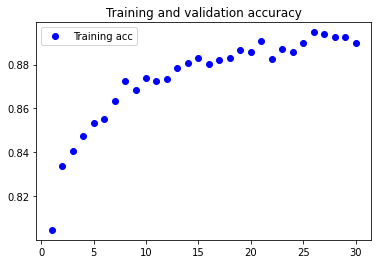

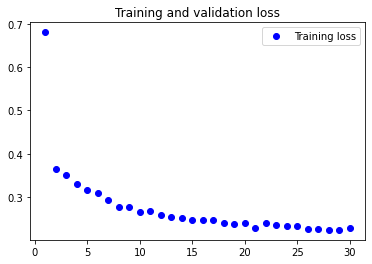

In [23]:
## Plot results
import matplotlib.pyplot as plt

print(history.history)

acc = history.history['acc']
loss = history.history['loss']
# val_acc = history.history['val_loss']
# val_loss = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b-', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
def evaluate(image_path):
    #Loading image slide at first level.
    image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = train_test_save.test_part_1(image_path,
                                                                                                     num_pixels=64,
                                                                                                     num_level = level[0])
    # Loading image slide at second level.                                                                                                 
    train_test_save.load_second_level(image_path,
                                  input_level = level[0],
                                  num_input_pixels = 64,
                                  output_level = level[1],
                                  num_output_pixels = 64)
                                                                                                     
    # Loading image slide at third level.                                                                                            
    train_test_save.load_second_level(image_path,
                                  input_level = level[0],
                                  num_input_pixels = 64,
                                  output_level = level[2],
                                  num_output_pixels = 64)

    # This function creates a dataset from the three levels the test image is segmented at. Then it predicts, and 
    # prints precision , recall, F1, confusion matrix and the generated hea                                                                                                 
    loading_data.test_part(image_path,
                                Inception_V3_RECONSTRUCTED,
                                tissue_regions,
                                slide_image_test,
                                tumor_mask,
                                image_depth,
                                image_width,
                                num_level_1 = level[0], 
                                num_level_2 = level[1],
                                num_level_3 = level[2])

In [31]:
testing_image_path_list = ['/content/drive/MyDrive/slides/tumor_110.tif']

In [33]:
image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = train_test_save.test_part_1(testing_image_path_list[0] ,
                                                                                                     num_pixels=64,
                                                                                                     num_level = level[0])

/content/drive/MyDrive/slides/tumor_110.tif /content/drive/MyDrive/slides/tumor_110_mask.tif


In [34]:
train_test_save.load_second_level(testing_image_path_list[0],
                                  input_level = level[0],
                                  num_input_pixels = 64,
                                  output_level = level[1],
                                  num_output_pixels = 64)

In [35]:
train_test_save.load_second_level(testing_image_path_list[0],
                                  input_level = level[0],
                                  num_input_pixels = 64,
                                  output_level = level[2],
                                  num_output_pixels = 64)

In [37]:
import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

def gen_image_paths_train(training_image_path_list, num_level):
    all_images_image_paths = []
    all_images_image_labels = []

    for i in training_image_path_list:

        slide_path = i

        img_num = slide_path.split('_')[1].strip(".tif")

        data_root_tumor = pathlib.Path('data/' + img_num + '/level_' + str(num_level) + '/tumor')
        all_image_paths_tumor = list(data_root_tumor.glob('*'))
        num_tumor_images = len(all_image_paths_tumor)

        data_root_notumor = pathlib.Path('data/' + img_num + '/level_' + str(num_level) + '/no_tumor')
        all_image_paths_notumor = list(data_root_notumor.glob('*'))
        random.shuffle(all_image_paths_notumor)
        all_image_paths_notumor = all_image_paths_notumor[0:num_tumor_images]

        all_image_paths = [str(path) for path in all_image_paths_tumor + all_image_paths_notumor]
        random.shuffle(all_image_paths)

        data_root = pathlib.Path('data/' + img_num + '/level_' + str(num_level))
        label_names = sorted(item.name for item in data_root.glob('*') if item.is_dir())
        label_to_index = dict((name, index) for index, name in enumerate(label_names))

        all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                            for path in all_image_paths]

        #update all image path lists
        all_images_image_paths = all_images_image_paths + all_image_paths
        all_images_image_labels = all_images_image_labels + all_image_labels

    return all_images_image_paths, all_images_image_labels

# Load and preprocess image.
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#Preprocess image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image

# Generate image paths
def gen_image_paths(slide_path, level_num):
    img_num = slide_path.split('_')[1].strip(".tif")
    img_test_folder = 'tissue_only'

    data_root = pathlib.Path('data/' + img_num + '/level_' + str(level_num) +'/' + img_test_folder)

    all_image_paths = list(data_root.glob('*'))
    all_image_paths = [str(path) for path in all_image_paths]

    return  all_image_paths

# Tumor predict mask.
def tumor_predict_mask(test, all_image_paths, depth, width):

    test = test[0:len(all_image_paths), :]
    img_num = np.zeros(len(all_image_paths))
    for i in range(len(all_image_paths)):
        img_num[i] = int(all_image_paths[i].strip('.jpg').split('/')[-1].split('_')[-1])

    # depth, width = int(np.ceil(slide_image.shape[0] / pixel_num)), int(np.ceil(slide_image.shape[1] / pixel_num))

    predictions = np.zeros((depth, width))
    conf_threshold = 0.85

    for i in range(len(test)):
        y = int(img_num[i] // width)
        x = int(np.mod(img_num[i], width))
        predictions[y, x] = int(test[i][1] > conf_threshold)

    return predictions

def create_tf_dataset_train(all_image_paths_1, all_image_paths_2, all_image_paths_3, all_image_labels):

    path_ds_1 = tf.data.Dataset.from_tensor_slices(all_image_paths_1)
    image_ds_1 = path_ds_1.map(load_and_preprocess_image, num_parallel_calls=8)

    path_ds_2 = tf.data.Dataset.from_tensor_slices(all_image_paths_2)
    image_ds_2 = path_ds_2.map(load_and_preprocess_image, num_parallel_calls=8)

    path_ds_3 = tf.data.Dataset.from_tensor_slices(all_image_paths_3)
    image_ds3_3 = path_ds_3.map(load_and_preprocess_image, num_parallel_calls=8)

    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

    image_label_ds = tf.data.Dataset.zip(((image_ds_1,image_ds_2, image_ds3_3), label_ds))

    BATCH_SIZE = 4

    steps_per_epoch = int(np.ceil(len(all_image_paths_1)/BATCH_SIZE))

    # Setting a shuffle buffer size larger than the dataset ensures that the data is completely shuffled.
    ds = image_label_ds.repeat()
    ds = ds.shuffle(buffer_size=4000)
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetches batches, asynchronously while the model is training.
    ds = ds.prefetch(1)


    return ds, steps_per_epoch

# Create tf dataset
def create_tf_dataset(all_image_paths_1, all_image_paths_2, all_image_paths_3):
    path_ds_1 = tf.data.Dataset.from_tensor_slices(all_image_paths_1)
    image_ds_1 = path_ds_1.map(load_and_preprocess_image, num_parallel_calls=8)

    path_ds_2 = tf.data.Dataset.from_tensor_slices(all_image_paths_2)
    image_ds_2 = path_ds_2.map(load_and_preprocess_image, num_parallel_calls=8)

    path_ds_3 = tf.data.Dataset.from_tensor_slices(all_image_paths_3)
    image_ds_3 = path_ds_3.map(load_and_preprocess_image, num_parallel_calls=8)
    image_test_ds = tf.data.Dataset.zip(((image_ds_1,image_ds_2, image_ds_3),))

    ## Dataset parameters
    BATCH_SIZE = 4

    steps_per_epoch = int(np.ceil(len(all_image_paths_1) / BATCH_SIZE))
    # Setting a shuffle buffer size larger than the dataset ensures that the data is completely shuffled.
    ds = image_test_ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetches batches, asynchronously while the model is training.
    ds = ds.prefetch(1)

    return ds, steps_per_epoch




def train_part(training_image_path_list, num_level_1, num_level_2, num_level_3 ):

    # change input here from a specific image to an image path
    all_image_paths_1, all_image_labels_1 = gen_image_paths_train(training_image_path_list, num_level_1)

    # create the second file path to mimic the 1st
    all_image_paths_2 = []
    for i in all_image_paths_1:
        split_str = i.split('/')
        split_str[2] = 'level_'+str(num_level_2)
        path_2_string = ''
        for j in split_str:
            if j == split_str[-1]:
                path_2_string = path_2_string + j
            else:
                path_2_string = path_2_string + j + '/'
        all_image_paths_2.append(path_2_string)

    all_image_paths_3 = []
    for i in all_image_paths_1:
        split_str = i.split('/')
        split_str[2] = 'level_'+str(num_level_3)
        path_3_string = ''
        for j in split_str:
            if j == split_str[-1]:
                path_3_string = path_3_string + j
            else:
                path_3_string = path_3_string + j + '/'
        all_image_paths_3.append(path_3_string)

    ## Create tf.Dataset for training
    ds, steps_per_epoch = create_tf_dataset_train(all_image_paths_1, all_image_paths_2, all_image_paths_3, all_image_labels_1)

    return ds, steps_per_epoch




In [ ]:
loading_data.test_part(image_path,
                                Inception_V3_RECONSTRUCTED,
                                tissue_regions,
                                slide_image_test,
                                tumor_mask,
                                image_depth,
                                image_width,
                                num_level_1 = level[0], 
                                num_level_2 = level[1],
                                num_level_3 = level[2])

In [40]:
all_image_paths_1 = gen_image_paths(testing_image_path_list[0],level[0])

In [41]:
all_image_paths_2 = []
for i in all_image_paths_1:
    split_str = i.split('/')
    split_str[2] = 'level_'+str(level[1])
    path_2_string = ''
    for j in split_str:
        if j == split_str[-1]:
            path_2_string = path_2_string + j
        else:
            path_2_string = path_2_string + j + '/'
    all_image_paths_2.append(path_2_string)

In [44]:
all_image_paths_3 = []
for i in all_image_paths_1:
    split_str = i.split('/')
    split_str[2] = 'level_'+str(level[2])
    path_3_string = ''
    for j in split_str:
        if j == split_str[-1]:
            path_3_string = path_3_string + j
        else:
            path_3_string = path_3_string + j + '/'
    all_image_paths_3.append(path_3_string)

In [45]:
ds_test, steps_per_epoch_test = create_tf_dataset(all_image_paths_1, all_image_paths_2, all_image_paths_3)

In [46]:
steps_per_epoch_test

1904

In [47]:
ds_test

<PrefetchDataset shapes: (((None, 128, 128, 3), (None, 128, 128, 3), (None, 128, 128, 3)),), types: ((tf.float32, tf.float32, tf.float32),)>

In [48]:
test_predicts = Inception_V3_RECONSTRUCTED.predict(ds_test, steps = steps_per_epoch_test)

In [50]:
predictions = tumor_predict_mask(test_predicts, all_image_paths_1, image_depth, image_width)

In [ ]:
predictions

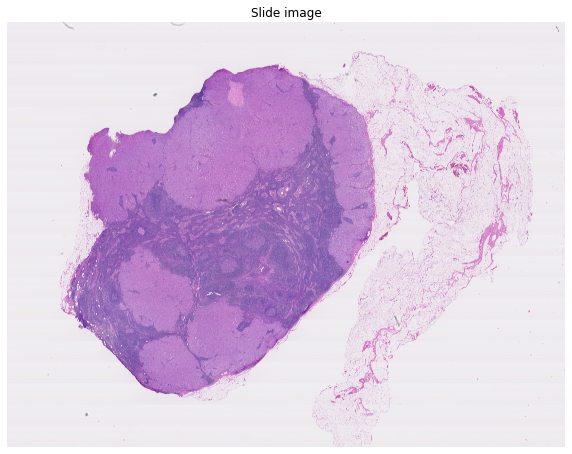

In [51]:
plt.figure(figsize=(10,10))
plt.title('Slide image')
plt.axis('off')
plt.imshow(slide_image_test,cmap='jet')

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Predicted image')
plt.axis('off')
plt.imshow(slide_image_test)
plt.imshow(predictions,cmap='jet', alpha=0.5)

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Actual mask')
plt.axis('off')
plt.imshow(slide_image_test)
plt.imshow(mask_image,cmap='jet', alpha=0.5)

/content/drive/MyDrive/slides/tumor_110.tif /content/drive/MyDrive/slides/tumor_110_mask.tif


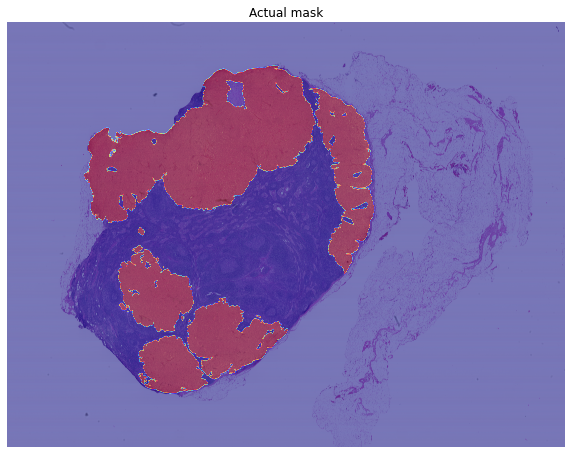

In [29]:
testing_image_path_list = ['/content/drive/MyDrive/slides/tumor_110.tif']
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[0])

In [ ]:
#VGG_19_RECONSTRUCTED.load_weights('/content/')

VGG_19_RECONSTRUCTED = keras.models.load_model('/content/trained_weights_final/')

In [14]:
VGG_19 = dense_conv_split_model()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [21]:

VGG_19.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])

history =VGG_19.fit(ds_train, epochs=100, steps_per_epoch=steps_per_epoch_train, verbose=1)

Epoch 1/100
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2499/2499 [==============================] - 197s 79ms/step - loss: 0.4825 - acc: 0.7674
Epoch 2/100
2499/2499 [==============================] - 206s 82ms/step - loss: 0.3889 - acc: 0.8191
Epoch 3/100
2499/2499 [==============================] - 203s 81ms/step - loss: 0.3642 - acc: 0.8331
Epoch 4/100
2499/2499 [==============================] - 162s 65ms/step - loss: 0.3213 - acc: 0.8699
Epoch 5/100
2499/2499 [==============================] - 101s 41ms/step - loss: 0.3110 - acc: 0.8746
Epoch 6/100
2499/2499 [==============================] - 101s 41ms/step - loss: 0.2921 - acc: 0.8826
Epoch 7/100
2499/2499 [==============================] - 101s 41ms/step - loss: 0.2885 - acc: 0.8812
Epoch 8/100
2499/2499 [==============================] - 101s 41ms/step - loss: 0.2903 - acc: 0.8841
Epoch 9/100
2499/2499 [==============================] - 101s 41ms/step - l

In [50]:
from tensorflow import keras
VGG_19_RECONSTRUCTED = keras.models.load_model('/content/trained_weights_final/')

### Saving and loading the model weights

In [30]:
VGG_19.save_weights('/content/trained_weights_finalH')
#VGG_19_RECONSTRUCTED.load_weights('/content/')
from tensorflow import keras
VGG_19_RECONSTRUCTED = keras.models.load_model('/content/trained_weights_final/')

In [26]:
from tensorflow import keras
VGG_19_RECONSTRUCTED = keras.models.load_model('/content/trained_weights_final/')

In [27]:
VGG_19_RECONSTRUCTED.summary()

Model: "dense_conv_split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  3145856   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple       

In [28]:
## Plot results
acc = history.history['acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training Accuracy')
plt.title('Accuracy')
plt.legend()


plt.show()

NameError: ignored

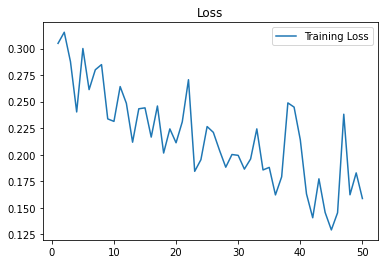

In [53]:
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training Loss')
plt.title('Loss')
plt.legend()


plt.show()

{'loss': [0.6807748675346375, 0.36523425579071045, 0.3516293168067932, 0.3290046751499176, 0.3162234425544739, 0.30915316939353943, 0.29232490062713623, 0.2759521007537842, 0.2765811085700989, 0.2661455571651459, 0.26674163341522217, 0.258136123418808, 0.25355321168899536, 0.25121980905532837, 0.24730269610881805, 0.24727082252502441, 0.2460959106683731, 0.2407718449831009, 0.23721231520175934, 0.23883198201656342, 0.2291136384010315, 0.23879684507846832, 0.23557353019714355, 0.2323029637336731, 0.2317020148038864, 0.2269601970911026, 0.22539807856082916, 0.22422201931476593, 0.22372861206531525, 0.22711998224258423], 'acc': [0.8045177459716797, 0.8337781429290771, 0.840449869632721, 0.8475028872489929, 0.8533167839050293, 0.8549370765686035, 0.8632291555404663, 0.8724742531776428, 0.8685665130615234, 0.8738086223602295, 0.8726648688316345, 0.8734273910522461, 0.8785741329193115, 0.880670964717865, 0.8831490874290466, 0.8800991177558899, 0.8819100260734558, 0.8831490874290466, 0.886580

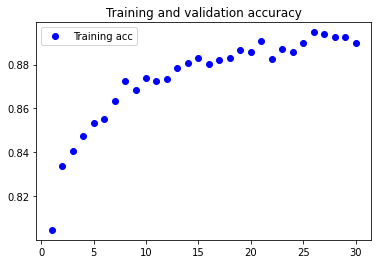

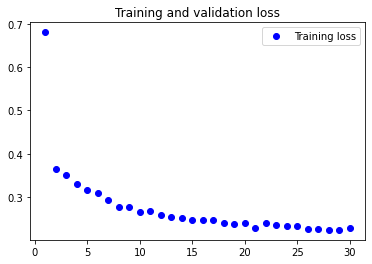

In [22]:
## Plot results
import matplotlib.pyplot as plt

print(history.history)

acc = history.history['acc']
loss = history.history['loss']
# val_acc = history.history['val_loss']
# val_loss = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b-', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing

In [54]:
def evaluate(image_path):
    #Loading image slide at first level.
    image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = train_test_save.test_part_1(image_path,
                                                                                                     num_pixels=64,
                                                                                                     num_level = level[0])
    # Loading image slide at second level.                                                                                                 
    train_test_save.load_second_level(image_path,
                                  input_level = level[0],
                                  num_input_pixels = 64,
                                  output_level = level[1],
                                  num_output_pixels = 64)
                                                                                                     
    # Loading image slide at third level.                                                                                            
    train_test_save.load_second_level(image_path,
                                  input_level = level[0],
                                  num_input_pixels = 64,
                                  output_level = level[2],
                                  num_output_pixels = 64)

    # This function creates a dataset from the three levels the test image is segmented at. Then it predicts, and 
    # prints precision , recall, F1, confusion matrix and the generated hea                                                                                                 
    loading_da.test_part(image_path,
                                model,
                                tissue_regions,
                                slide_image_test,
                                tumor_mask,
                                image_depth,
                                image_width,
                                num_level_1 = level[0], 
                                num_level_2 = level[1],
                                num_level_3 = level[2])

### Defining path of image tif files for those files we will test on

In [ ]:
testing_image_path_list = ['tumor_110.tif', 'tumor_101.tif', 'tumor_096.tif']

In [55]:
testing_image_path_list = ['/content/drive/MyDrive/slides/tumor_110.tif']
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[0])

In [44]:
testing_image_path_list = ['/content/drive/MyDrive/slides/tumor_091.tif']

/content/drive/MyDrive/slides/tumor_091.tif /content/drive/MyDrive/slides/tumor_091_mask.tif
Slide image
Predicted image
Actual mask
ROC AUC score:  0.8757350021898461
              precision    recall  f1-score   support

           0       0.99      0.99      0.99  12615675
           1       0.88      0.76      0.82    728728

    accuracy                           0.98  13344403
   macro avg       0.94      0.88      0.90  13344403
weighted avg       0.98      0.98      0.98  13344403



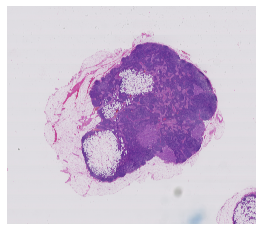

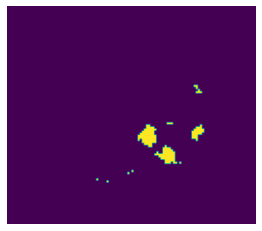

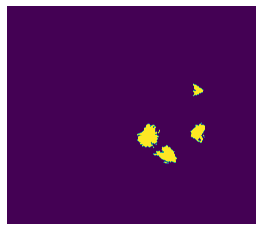

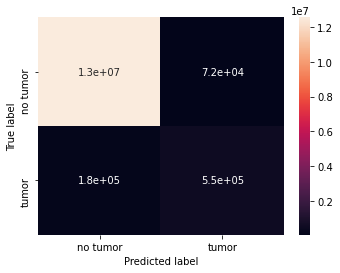

In [56]:
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[0])

/content/drive/MyDrive/slides/tumor_110.tif /content/drive/MyDrive/slides/tumor_110_mask.tif
Slide image
Predicted image
Actual mask
ROC AUC score:  0.8124541043428112
              precision    recall  f1-score   support

           0       0.74      0.98      0.85  16480576
           1       0.97      0.64      0.77  15621942

    accuracy                           0.82  32102518
   macro avg       0.86      0.81      0.81  32102518
weighted avg       0.86      0.82      0.81  32102518



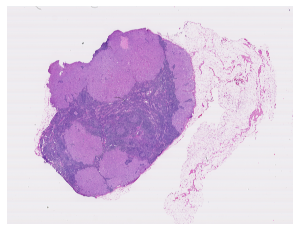

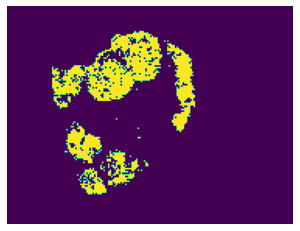

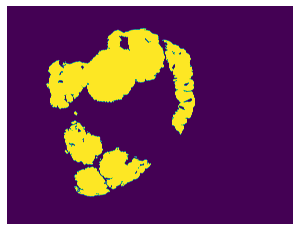

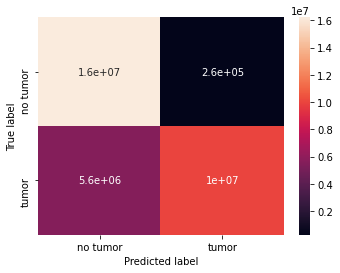

In [45]:
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[0])

## Evaluating on slide 1 

tumor_110.tif tumor_110_mask.tif
Slide image
Predicted image
Actual mask
ROC AUC score:  0.9013598994152591
              precision    recall  f1-score   support

           0       0.85      0.98      0.91 261054827
           1       0.98      0.82      0.89 247227245

   micro avg       0.90      0.90      0.90 508282072
   macro avg       0.92      0.90      0.90 508282072
weighted avg       0.91      0.90      0.90 508282072



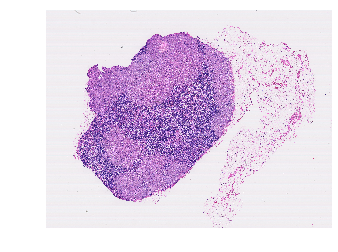

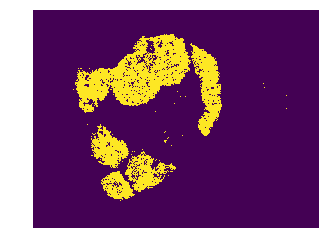

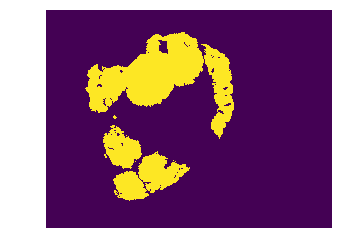

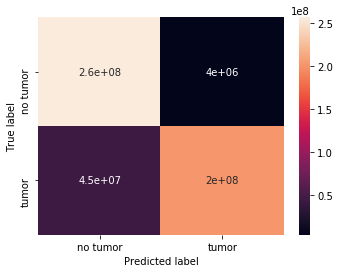

In [ ]:
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[0])

## Evaluating on slide 2 

tumor_101.tif tumor_101_mask.tif
Slide image
Predicted image
Actual mask
ROC AUC score:  0.560891140145724
              precision    recall  f1-score   support

           0       1.00      0.13      0.22 491317391
           1       0.10      1.00      0.18  46266139

   micro avg       0.20      0.20      0.20 537583530
   macro avg       0.55      0.56      0.20 537583530
weighted avg       0.92      0.20      0.22 537583530



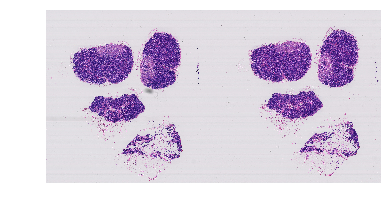

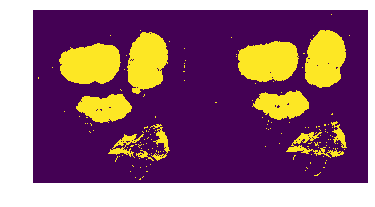

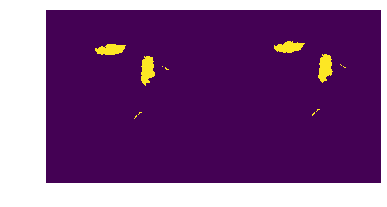

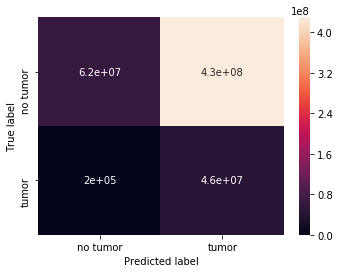

In [ ]:
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[1])

## Evaluating on slide 3

tumor_096.tif tumor_096_mask.tif
Slide image
Predicted image
Actual mask
ROC AUC score:  0.8662605524602267
              precision    recall  f1-score   support

           0       1.00      0.95      0.98 398316870
           1       0.18      0.78      0.29   5084806

   micro avg       0.95      0.95      0.95 403401676
   macro avg       0.59      0.87      0.63 403401676
weighted avg       0.99      0.95      0.97 403401676



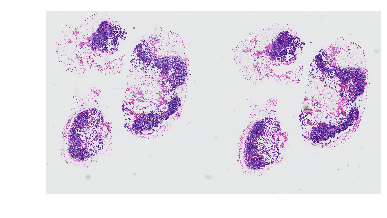

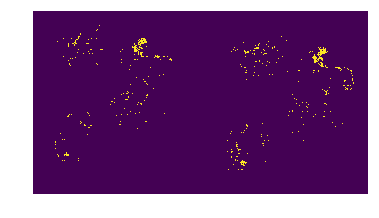

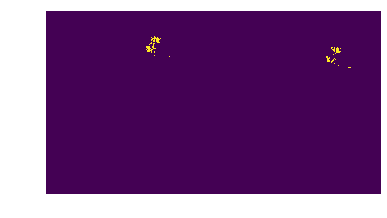

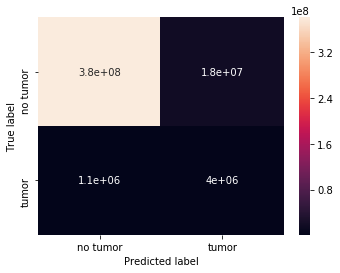

In [ ]:
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[2])